In [375]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# SK-learn libraries for data processing.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier    
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [376]:
# Load data using pandas.
train_data = pd.read_csv('data/train_users_2.csv')
test_data = pd.read_csv('data/test_users.csv')
print "Train data shape: {0}".format(train_data.shape)
print "--------------Train Data----------------------"
print train_data.info()
print "----------------------------------------------"

print "\n"
print "Test data shape: {0}".format(test_data.shape)
print "---------------Test Data----------------------"
print test_data.info()
print "----------------------------------------------"

Train data shape: (213451, 16)
--------------Train Data----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float

In [377]:
# Import sessions data.
sessions= pd.read_csv('../sessions.csv')

print(sessions.head())
print(sessions.info())
print(sessions.apply(lambda x: x.nunique(),axis=0))

      user_id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                  NaN   
1  d1mm9tcy42  search_results       click  view_search_results   
2  d1mm9tcy42          lookup         NaN                  NaN   
3  d1mm9tcy42  search_results       click  view_search_results   
4  d1mm9tcy42          lookup         NaN                  NaN   

       device_type  secs_elapsed  
0  Windows Desktop           319  
1  Windows Desktop         67753  
2  Windows Desktop           301  
3  Windows Desktop         22141  
4  Windows Desktop           435  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 564.4+ MB
None
user_id          135483
action              359
action_type          10
act

In [378]:
# Aggregate sessions data.
grpby = sessions.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
grpby.columns = ['user_id','secs_elapsed']

action_type = pd.pivot_table(sessions, index = ['user_id'],
                             columns = ['action_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()
device_type = pd.pivot_table(sessions, index = ['user_id'],
                             columns = ['device_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()

sessions_data = pd.merge(action_type,device_type,on='user_id',how='inner')
sessions_data = pd.merge(sessions_data,grpby,on='user_id',how='inner')
print(sessions_data.head())
print sessions_data.iloc[0]

      user_id  -unknown-_x  booking_request  booking_response  click  data  \
0  00023iyk9l            0                1                 0      4     9   
1  0010k6l0om            5                0                 0     16     9   
2  001wyh0pz8            6                0                 0     66     2   
3  0028jgx1x1            1                0                 0      9     5   
4  002qnbzfs5          184                1                 0    140   140   

   message_post  modify  partner_callback  submit      ...       \
0             1       0                 1       0      ...        
1             0       0                 1       0      ...        
2             0       0                 0       3      ...        
3             0       0                 0       1      ...        
4            16       0                 0      15      ...        

   Linux Desktop  Mac Desktop  Opera Phone  Tablet  Windows Desktop  \
0              0           36            0       0       

In [379]:
# Join session data with train and test data.
joined_train_data = pd.concat([train_data, sessions_data], axis=1)
print joined_train_data.head()
print joined_train_data.shape

joined_test_data = pd.concat([test_data, sessions_data], axis=1, join='inner')
print joined_test_data.head()
print joined_test_data.shape

           id date_account_created  timestamp_first_active date_first_booking  \
0  gxn3p5htnn           2010-06-28          20090319043255                NaN   
1  820tgsjxq7           2011-05-25          20090523174809                NaN   
2  4ft3gnwmtx           2010-09-28          20090609231247         2010-08-02   
3  bjjt8pjhuk           2011-12-05          20091031060129         2012-09-08   
4  87mebub9p4           2010-09-14          20091208061105         2010-02-18   

      gender  age signup_method  signup_flow language affiliate_channel  \
0  -unknown-  NaN      facebook            0       en            direct   
1       MALE   38      facebook            0       en               seo   
2     FEMALE   56         basic            3       en            direct   
3     FEMALE   42      facebook            0       en            direct   
4  -unknown-   41         basic            0       en            direct   

       ...      Linux Desktop Mac Desktop Opera Phone Tablet W

### Exploring the data

#### Analysis of class distribution

Check training data to see how classes are distributed. It is obvious the training data is heavily imbalanced. 

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64


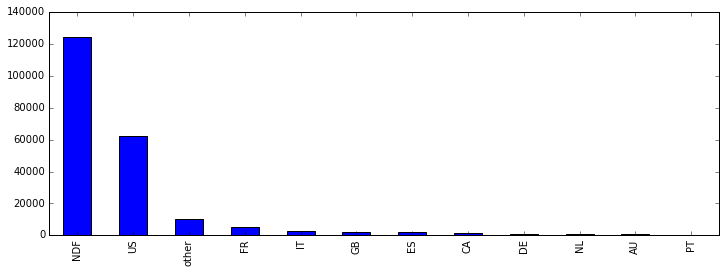

In [381]:
plt.figure(figsize=(12,4))
country_dist = train_data["country_destination"].value_counts()
plt.subplot(1,1,1)
country_dist.plot.bar()

print country_dist*1.0 / sum(country_dist)

#### Analysis of age data
We'll start with the assumption that valid age ranges should be between 18-100 since the minimum age according to the Terms of Service is 18. Any values outside of this range should be cleaned into valid values or set to 0
as invalid.

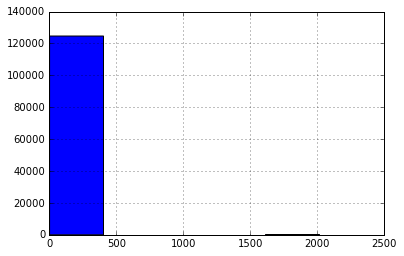

In [157]:
# Get all age values that are greater than zero.
GTE_zero_age = train_data[train_data.age >= 0].age
# Plot a histogram of these values.
GTE_zero_age.hist(bins=5)

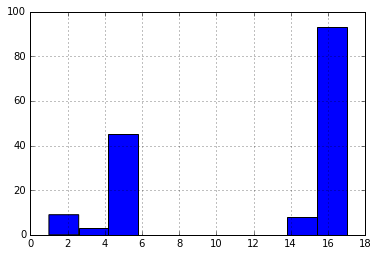

In [158]:
# Get all age values that are between 0 and 18.
under_18 = GTE_zero_age[GTE_zero_age < 18]
under_18.hist()
# All these values should be treated as invalid values.

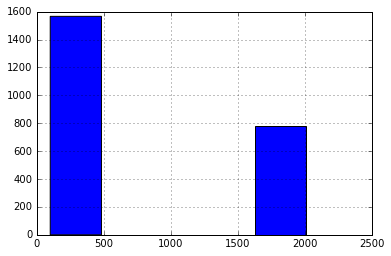

In [159]:
# From this, we can see that there are many large values.
# Assuming anything above 100 is not a valid, let's plot the
# histogram of those values.
GT_150 = train_data[train_data.age > 100].age
GT_150.hist(bins=5)
# We can't make much sense out of values between 100-1915 so
# those should be treated as invalid values as well.

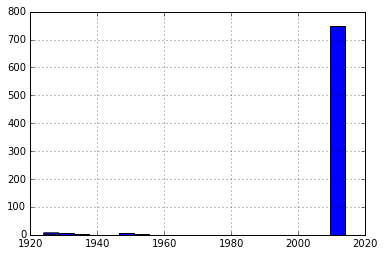

In [160]:
# Let's look more closely at those values greater than 1915.
GT_1915 = train_data[train_data.age > 1915].age
GT_1915.hist(bins=20)
# We have some values between 1915 and 1997 which we can
# assume could be birth years.
# The large number of values > 1997 are likely the current
# year the user registered.

In [161]:
# Helper function to clean up the age data based off
# this analysis in both the training and test data.
def CleanAgeData(df):
    age_data = df.age
    # Set missing values to -1.
    age_data = age_data.fillna(-1)
    # Set invalid values to 0.
    # Values between 0-18 are considered invalid.
    age_data[age_data.isin(range(0,18))] = 0
    # Values between 100-1915 are considered invalid.
    age_data[age_data.isin(range(101,1915))] = 0
    # Values >2010 are considered invalid.
    age_data[age_data > 1997] = 0
    # Compute age for values between 1915-1997.
    age_data[age_data.isin(range(1915,1998))] = 2015 - age_data[age_data.isin(range(1915,1998))]
    return age_data

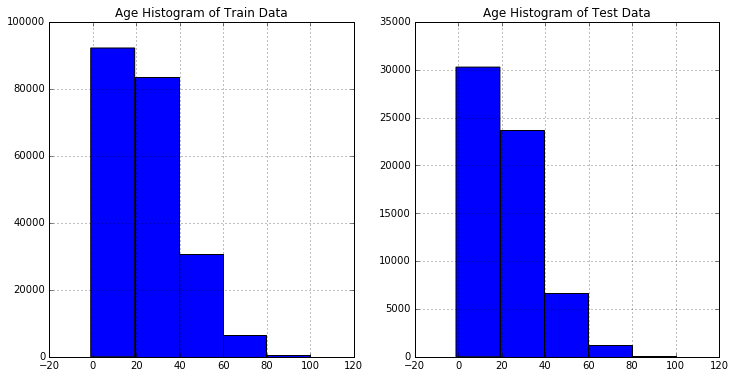

In [162]:
# Clean up training and test age data and plot cleaned data.
plt.figure(figsize=(12, 6))
train_age_data = CleanAgeData(train_data)
plt.subplot(1, 2, 1)
train_age_data.hist(bins=5)
plt.title("Age Histogram of Train Data")

test_age_data = CleanAgeData(test_data)
plt.subplot(1, 2, 2)
test_age_data.hist(bins=5)
plt.title("Age Histogram of Test Data")

#### Analysis of Date Data

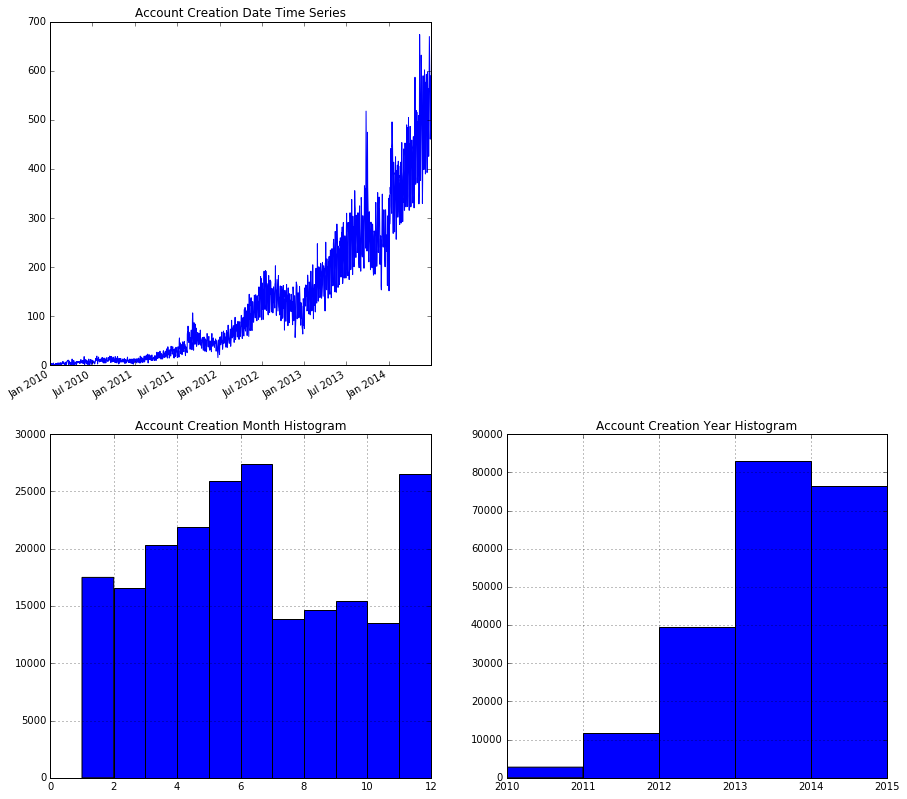

In [163]:
# Plot account created time series data.
plt.figure(figsize=(15, 15))
account_created_data = pd.to_datetime(train_data.date_account_created).value_counts()
plt.subplot(2, 2, 1)
account_created_data.plot()
plt.title("Account Creation Date Time Series")

# Plot account created month data.
account_created_month = pd.to_datetime(train_data.date_account_created).dt.month
plt.subplot(2, 2, 3)
account_created_month.hist(bins=range(1,13))
plt.title("Account Creation Month Histogram")

# Plot account created year data.
account_created_year = pd.to_datetime(train_data.date_account_created).dt.year
ax = plt.subplot(2, 2, 4)
account_created_year.hist(bins=[2010,2011,2012,2013,2014,2015])
ax.ticklabel_format(useOffset=False)
plt.title("Account Creation Year Histogram")

#### Analysis of Session Data

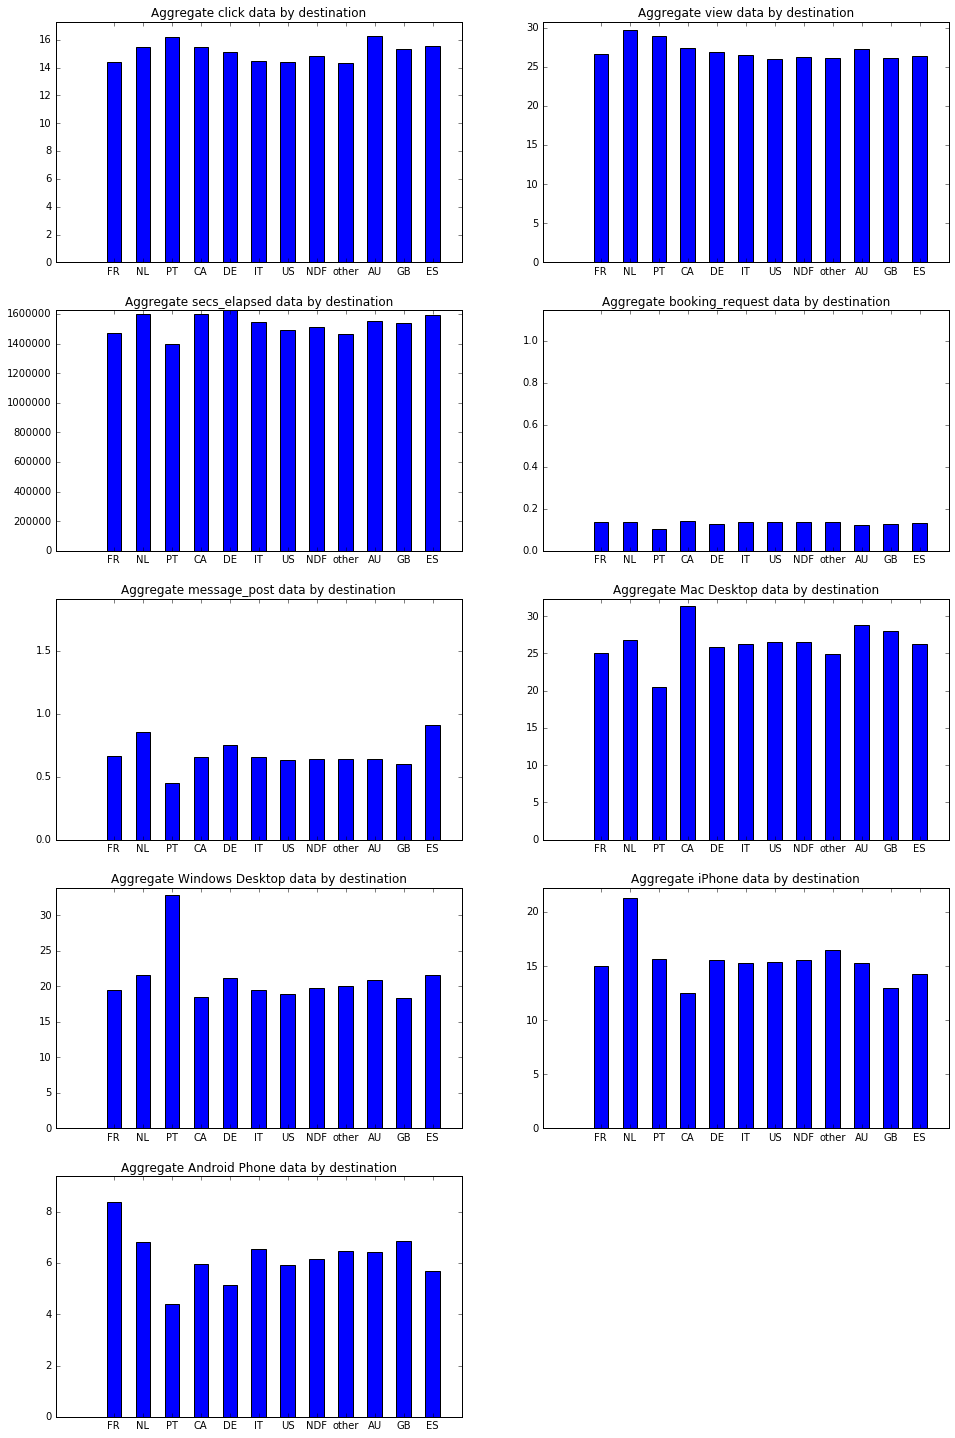

In [382]:
def SessionDataHist(column, plt_index):
    columns_to_extract = ['country_destination', column]
    agg_data = joined_train_data[columns_to_extract].groupby(
        ['country_destination'])[column].mean().reset_index()
    agg_dict = dict(zip(agg_data['country_destination'], agg_data[column]))
    X = np.arange(len(agg_dict))
    
    plt.subplot(5, 2, plt_index)
    plt.bar(X, agg_dict.values(), align='center', width=0.5)
    plt.xticks(X, agg_dict.keys())
    ymax = max(agg_dict.values()) + 1
    plt.ylim(0, ymax)
    plt.title("Aggregate {0} data by destination".format(column))

plt.figure(figsize=(16, 25))
# Choose some interesting columns to plot.
columns_to_plot = ['click', 'view', 'secs_elapsed', 'booking_request',
                   'message_post', 'Mac Desktop', 'Windows Desktop',
                   'iPhone', 'Android Phone']
for i,column in enumerate(columns_to_plot):
    SessionDataHist(column, i+1)

### Preparing Data

In [392]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add cleaned version of age data to features.
    age_data = CleanAgeData(data)
    age_buckets = age_data.divide(5).apply(np.floor)
    # Add age data to feature set.
    features_data = np.column_stack((features_data, np.array(age_buckets)))
    
    # Add session data to feature set.
#     sessions_columns = ['message_post', 'Mac Desktop', 'Windows Desktop',
#                         'iPhone', 'Android Phone']
#     features_data = np.column_stack((features_data, np.array(data[sessions_columns])))
    
    # Add account creation data (month and year).
    # These are currently commented out because they actually make the model performance worse.
    # Leaving them in since they might be useful for predicting NDF or booking.
#     account_creation_month = pd.to_datetime(data.date_account_created).dt.month
#     features_data = np.column_stack((features_data, np.array(account_creation_month)))
#     account_created_year = pd.to_datetime(data.date_account_created).dt.year
#     features_data = np.column_stack((features_data, np.array(account_created_year)))
    
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(joined_train_data)
test_data_x = ExtractFeatures(joined_test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


In [413]:
# Split train data into training and dev sets.
train_data_size = (len(train_data_x))/5*4
train_x, train_y = train_data_x[:train_data_size], train_data_y[:train_data_size]
dev_x, dev_y= train_data_x[train_data_size:], train_data_y[train_data_size:]

# save dev id to be used in score calculation
dev_id = np.array(train_data["id"][train_data_size:])
dev_dict = dict(zip(dev_id, dev_y))

print train_x.shape, train_y.shape
print dev_x.shape, dev_y.shape, dev_id.shape

#******************************************
# Try SMOTE here
#******************************************
# print "\nTraining data after SMOTE"

# country = 'FR'
# train_x_c = train_x[train_y == country]

# #SMOTE(minority data, new data size, NN steps)
# #To double minority data example size, set N=1
# #NN default = 5 neighbours
# N = 4
# train_x_c2 =  SMOTE(train_x_c,N*100,5)

# #Append new data to train_x
# train_x = np.vstack((train_x, train_x_c2))
# #Append label to train_y
# new_label = []
# for i in range(N * len(train_x_c)):
#     new_label.append(country)
# train_y = np.concatenate((train_y, np.array(new_label)))

# print train_x.shape, train_y.shape

#****** End of SMOTE test block **************

(170760, 6) (170760,)
(42691, 6) (42691,) (42691,)


In [386]:
# Calculate DCG score based on Kaggle evaluation doc
def FinalScore(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            #scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    #scores.append((cur_id, dcg))
    
    return score/num_pred
    #return scores

In [388]:
# Build on top of DCG score function, output more prediction data
def Dump(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    scores.append((cur_id, dcg))
    
    #Output more info for error analysis
    dev_scores = dict(scores)
    dump = []
    temp_list = []
    for i in range(len(dev_x)):        
        temp_list = [dev_id[i], dev_y[i], dev_scores[dev_id[i]]]        
        dump.append(dev_x[i].tolist() + temp_list) 

    output = pd.DataFrame(dump, columns=["gender", "signup_method", "language", "first_device_type", 
                                         "first_browser", "age", "id", "country","score"])
    output.to_csv("dev_x_score.csv", index=False)
    
    buckets = [1.0, 0.6309, 0.5, 0.4307, 0.3869, 0.0]    
    plt.figure(figsize=(15, 15))
    
    for i in range(len(buckets)):    
        pred_count = output[abs(output.score - buckets[i]) < 0.001].country.value_counts()
        plt.subplot(2, 3, i+1)
        pred_count.plot.bar()

        if(i<5):
            plt.title("Correct prediction on attempt " + str(i+1))
            print "\nCorrect prediction dist on attempt %d"%(i+1)
        else:
            plt.title("Incorrect prediction dist")
            print "\nIncorrect prediction dist"
            
        print pred_count
    
    print "\nScore: %7.5f"%(score/num_pred)
    
    return 

In [387]:
# Helper function to return top 5 prediction result per example
# given a trained model.
def Predict_Top5(m):
    prob_est = m.predict_proba(dev_x)
    predictions = []
    
    for i, example in enumerate(prob_est):
        sorted_scores = np.sort(example)
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = example.tolist().index(score)
            predictions.append((dev_id[i], m.classes_[index_of_score]))
    
    return predictions

In [389]:
# Output countries that were predicted with the highest probability (first)
# while the correct country was predcited with lower probability (second)
def WhichIsFirst(predictions, country):
    
    # turn on to print debugging detail
    to_print = False

    # init variables
    k, first, label = 0, '', ''
    tally = {}
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        
        #start a new group, reset trackers       
        if p[0] != cur_id:
            k, cur_id= 0, p[0]

        k += 1         
        label = dev_dict[cur_id]
        if to_print: print "%d) %s %s.....label=%s"%(k, p[0], p[1], label)
        
        # record the country with highest probability (first)
        if k==1:                 
            first = p[1]
        
        # update dict if 2nd prediction is the correct prediction and the country inquired
        if k==2 and p[1] != first and p[1] == country and label == country :
            
            #add new keys in dict
            if first not in tally:
                if to_print: print "..........add %s to dict"%(first)
                tally[first] = 0
            # increase tally
            tally[first] += 1
            
    #output countries predicted first in decending order
    for i, d in enumerate( sorted(tally.items(), key=lambda x: x[1], reverse=True)):
        print "%6s %5d"%(d[0], d[1])

The following SMOTE function was copied from this source:
    http://comments.gmane.org/gmane.comp.python.scikit-learn/5278

In [390]:
def SMOTE(T, N, k):
    """
    Returns (N/100) * n_minority_samples synthetic minority samples.

    Parameters
    ----------
    T : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 

    Returns
    -------
    S : array, shape = [(N/100) * n_minority_samples, n_features]
    """    
    n_minority_samples, n_features = T.shape
    
    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")
    
    N = N/100
    n_synthetic_samples = N * n_minority_samples
    S = np.zeros(shape=(n_synthetic_samples, n_features))
    
    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    
    #Calculate synthetic samples
    for i in xrange(n_minority_samples):
        nn = neigh.kneighbors(T[i], return_distance=False)
        for n in xrange(N):
            nn_index = random.choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it 
            while nn_index == i:
                nn_index = random.choice(nn[0])
                
            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    
    return S


### Multinomial Naive Bayes

Commented out for now....

In [171]:
# Train Naive Bayes Model.
#mnb = MultinomialNB()
#mnb.fit(train_x, train_y)
#print "Classes: {0}".format(mnb.classes_)
#print "Class count: {0}".format(mnb.class_count_)
#print "Accuracy: {0}".format(mnb.score(dev_x, dev_y))
#predictions = mnb.predict(dev_x)
#print "F1 score: {0}".format(metrics.f1_score(dev_y,predictions,average="weighted"))

In [172]:
# Predict test data using multinomial model.
#test_predictions = mnb.predict(test_data_x)
#output = pd.concat([test_data["id"], pd.DataFrame(test_predictions, columns=["country"])], axis=1)
# Update version everytime!
#version = 1
#output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1304 with score of 0.63168.

In [173]:
# Predict Top 5 cities for each test example using multinomial model.
#prob_est = mnb.predict_proba(test_data_x)
#predictions = []
#for i, example in enumerate(prob_est):
#    sorted_scores = np.sort(example)
#    top_5 = sorted_scores[len(sorted_scores) - 5:]
#    for score in reversed(top_5):
#        index_of_score = example.tolist().index(score)
#        predictions.append((test_data["id"][i], mnb.classes_[index_of_score]))
#output2 = pd.DataFrame(predictions, columns=["id", "country"])
#version = 2
#output2.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1142 with score of 0.79584.

### Logistic Regression

In [414]:
# Train Logistic Regression Model.
lr = LogisticRegression(penalty='l2')
lr.fit(train_x, train_y)
lr_predictions = lr.predict(dev_x)
print "F1 score: {0}".format(metrics.f1_score(dev_y,lr_predictions,average="weighted"))

F1 score: 0.563205147623


In [415]:
# Predict Top 5 cities for each test example using logistic regression model.
prob_est = lr.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], lr.classes_[index_of_score]))
# output3 = pd.DataFrame(predictions, columns=["id", "country"])
# version = 6
# output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1049 with score of 0.85894.


Correct prediction dist on attempt 1
NDF    23748
US      3125
Name: country, dtype: int64

Correct prediction dist on attempt 2
US     8218
NDF    2600
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1991
NDF         3
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR    848
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT    494
ES     52
GB     19
Name: country, dtype: int64

Incorrect prediction dist
GB    416
ES    366
CA    300
NL    160
DE    150
AU     77
IT     70
PT     54
Name: country, dtype: int64

Score: 0.82638


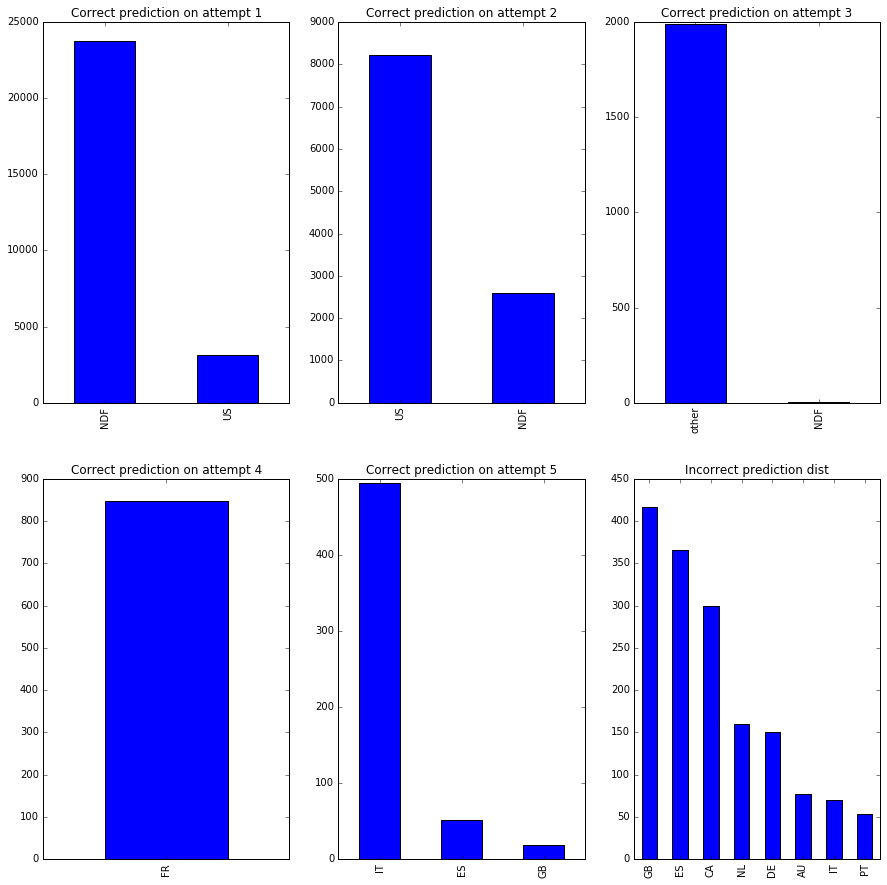

In [416]:
Dump(Predict_Top5(lr))

### Random Forest

In [418]:
# Train Random forest.
rf= RandomForestClassifier(n_estimators=10)
rf.fit(train_x, train_y)
rf_predictions = rf.predict(dev_x)
print "F1 score: {0}".format(metrics.f1_score(dev_y,rf_predictions,average="weighted"))

F1 score: 0.606956862473


In [419]:
# Predict Top 5 cities for each test example using Random forest model.
prob_est = rf.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], rf.classes_[index_of_score]))
# output4 = pd.DataFrame(predictions, columns=["id", "country"])
# version = 4
# output4.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1137 with score of 0.82136.


final score: 0.82783

Correct prediction dist on attempt 1
NDF      22320
US        5431
other        2
DE           1
FR           1
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       5692
NDF      3918
other      18
FR          4
ES          1
IT          1
CA          1
GB          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1627
FR         90
US         72
NDF        37
IT         12
GB          4
NL          3
ES          2
DE          1
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR       549
other    161
IT        38
GB        20
ES        18
US        10
NDF        7
CA         7
DE         1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       223
GB        91
FR        76
ES        74
other     33
CA        10
DE         4
US         2
NL         1
AU         1
NDF        1
Name: country, dtype: int64

Incorrect prediction dist
ES       323
GB       319
IT       290
CA       

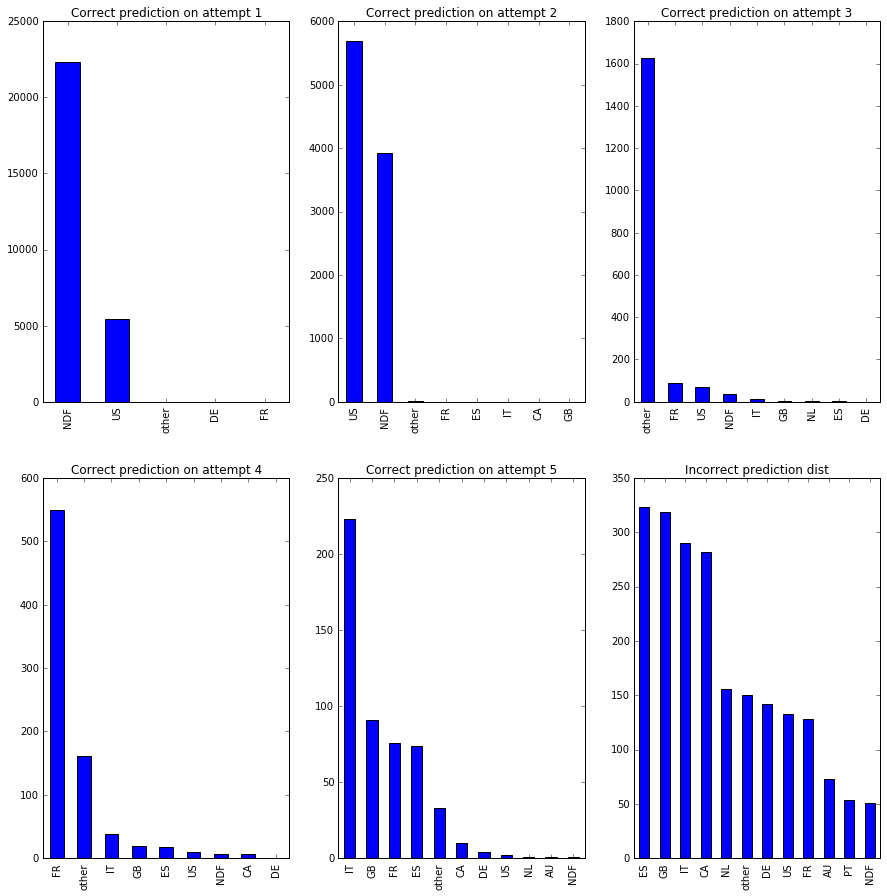

In [420]:
print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(rf)))
Dump(Predict_Top5(rf))

In [421]:
# Try voting ensemble
vc = VotingClassifier(estimators=[ ('lr', lr), ('rf', rf)], voting='soft')
vc.fit(train_x, train_y)

# Predict Top 5 cities for each test example using Random forest model.
prob_est = vc.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], vc.classes_[index_of_score]))
# output = pd.DataFrame(predictions, columns=["id", "country"])
# version = 7
# output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1032 with score of 0.86252.

print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(vc)))


final score: 0.83405



Correct prediction dist on attempt 1
NDF      22550
US        5304
other        1
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       6017
NDF      3783
other       1
ES          1
IT          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1903
FR         30
US         22
NDF        17
IT          6
DE          2
NL          2
GB          1
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR       737
other     68
IT        16
GB        12
ES         9
CA         2
NDF        1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       339
GB        69
FR        57
ES        52
other     16
CA         8
DE         3
NL         1
Name: country, dtype: int64

Incorrect prediction dist
ES       356
GB       353
CA       290
IT       202
NL       157
DE       145
AU        77
PT        54
FR        24
other      2
Name: country, dtype: int64

Score: 0.83405


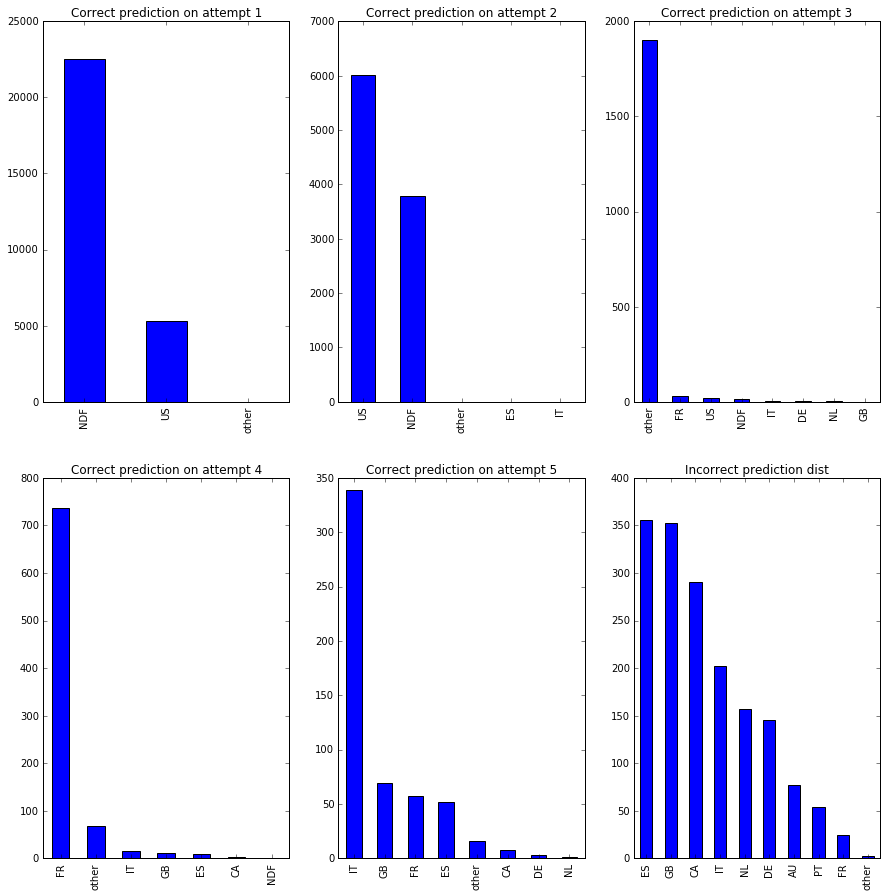

In [422]:
Dump(Predict_Top5(vc))

### 3-Level Model

In [423]:
# Use LabelBinarizer to transform training labels matrix of binary values.
lb = preprocessing.LabelBinarizer()
labels_train = lb.fit_transform(train_y)
labels_dev = lb.transform(dev_y)
print lb.classes_
# Note that NDF is index 7 and US is index 10.

['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NDF' 'NL' 'PT' 'US' 'other']


In [424]:
# Train Logistic Regression for NDF vs non-NDF.
lr_ndf = LogisticRegression(penalty='l2')
lr_ndf.fit(train_x, labels_train[:,7])
lr_ndf_predictions = lr_ndf.predict(dev_x)
print "NDF Logistic Regression F1 score: {0}".format(
    metrics.f1_score(labels_dev[:,7],lr_ndf_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(lr_ndf_predictions == labels_dev[:,7]))
print "Positive predictions: {0}".format(np.sum(lr_ndf_predictions==1))
print "Negative predictions: {0}".format(np.sum(lr_ndf_predictions==0))

NDF Logistic Regression F1 score: 0.768891632131
Num correct: 29586
Positive predictions: 30354
Negative predictions: 12337


In [425]:
# Train Logistic Regression for US vs non-US.
# Get all non-NDF examples
us_train_x = np.array(
    [train_x[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0)])
us_dev_x = np.array(
    [dev_x[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0)])
us_train_y = np.array(
    [labels_train[i,10] for i in range(len(labels_train)) if (labels_train[i,7] == 0)])
us_dev_y = np.array(
    [labels_dev[i,10] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0)])

# Train Logistic Regression model on non-NDF data to classify US vs Non-US.
lr_us = LogisticRegression(penalty='l2')
lr_us.fit(us_train_x, us_train_y)
lr_us_predictions = lr_us.predict(us_dev_x)
print "US Logistic Regression F1 score: {0}".format(
    metrics.f1_score(us_dev_y,lr_us_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(lr_us_predictions == us_dev_y))
print "Positive predictions: {0}".format(np.sum(lr_us_predictions==1))
print "Negative predictions: {0}".format(np.sum(lr_us_predictions==0))
print "\n"

rf_us= RandomForestClassifier()
rf_us.fit(us_train_x, us_train_y)
rf_us_predictions = rf_us.predict(us_dev_x)
print "US Random Forest F1 score: {0}".format(
    metrics.f1_score(us_dev_y,rf_us_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(rf_us_predictions == us_dev_y))
print "Positive predictions: {0}".format(np.sum(rf_us_predictions==1))
print "Negative predictions: {0}".format(np.sum(rf_us_predictions==0))
print "\n"

vc_us = VotingClassifier(estimators=[ ('lr', lr_us), ('rf', rf_us)], voting='soft')
vc_us.fit(us_train_x, us_train_y)
vc_us_predictions = vc_us.predict(us_dev_x)
print "US voting F1 score: {0}".format(
    metrics.f1_score(us_dev_y,vc_us_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(vc_us_predictions == us_dev_y))
print "Positive predictions: {0}".format(np.sum(vc_us_predictions==1))
print "Negative predictions: {0}".format(np.sum(vc_us_predictions==0))

US Logistic Regression F1 score: 0.819492107069
Num correct: 11343
Positive predictions: 16340
Negative predictions: 0


US Random Forest F1 score: 0.813631211379
Num correct: 11243
Positive predictions: 16006
Negative predictions: 334


US voting F1 score: 0.817954388891
Num correct: 11319
Positive predictions: 16238
Negative predictions: 102


In [426]:
# Train models for classifying non NDF/US examples.
# Get all non-NDF/US examples
other_train_x = np.array(
    [train_x[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0 and labels_train[i,10] == 0)])
other_train_y = np.array(
    [train_y[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0 and labels_train[i,10] == 0)])
other_dev_x = np.array(
    [dev_x[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0 and labels_train[i,10] == 0)])
other_dev_y = np.array(
    [dev_y[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0 and labels_train[i,10] == 0)])

lr_other = LogisticRegression(penalty='l2')
lr_other.fit(other_train_x, other_train_y)
lr_other_predictions = lr_other.predict(other_dev_x)
print "Non-NDF/US logistic regression F1 score: {0}".format(
    metrics.f1_score(other_dev_y,lr_other_predictions,average="weighted"))

rf_other= RandomForestClassifier()
rf_other.fit(other_train_x, other_train_y)
rf_other_predictions = rf_other.predict(other_dev_x)
print "Non-NDF/US random forest F1 score: {0}".format(
    metrics.f1_score(other_dev_y,rf_other_predictions,average="weighted"))

vc_other = VotingClassifier(estimators=[ ('lr', lr_other), ('rf', rf_other)], voting='soft')
vc_other.fit(other_train_x, other_train_y)
vc_other_predictions = vc_other.predict(other_dev_x)
print "Non-NDF/US voting F1 score: {0}".format(
    metrics.f1_score(other_dev_y,vc_other_predictions,average="weighted"))

Non-NDF/US logistic regression F1 score: 0.0264627676823
Non-NDF/US random forest F1 score: 0.0329531994853
Non-NDF/US voting F1 score: 0.0298198458662


Case 1 count: 15142
Case 2 count: 27254
Case 3 count: 295
Final Score: 0.715729011291

Correct prediction dist on attempt 1
NDF      12072
US        9337
other       16
Name: country, dtype: int64

Correct prediction dist on attempt 2
NDF      11847
US        1849
other      452
FR          11
GB           2
IT           1
CA           1
DE           1
ES           1
Name: country, dtype: int64

Correct prediction dist on attempt 3
FR       154
other     28
IT         7
ES         4
GB         4
CA         1
Name: country, dtype: int64

Correct prediction dist on attempt 4
IT       42
FR       30
GB       29
ES       13
other     5
CA        3
DE        2
NL        1
Name: country, dtype: int64

Correct prediction dist on attempt 5
GB    39
IT    28
ES    25
FR     6
CA     5
NL     1
Name: country, dtype: int64

Incorrect prediction dist
NDF      2432
other    1490
FR        647
IT        486
ES        375
GB        361
CA        290
NL        158
US        157
DE        147
AU       

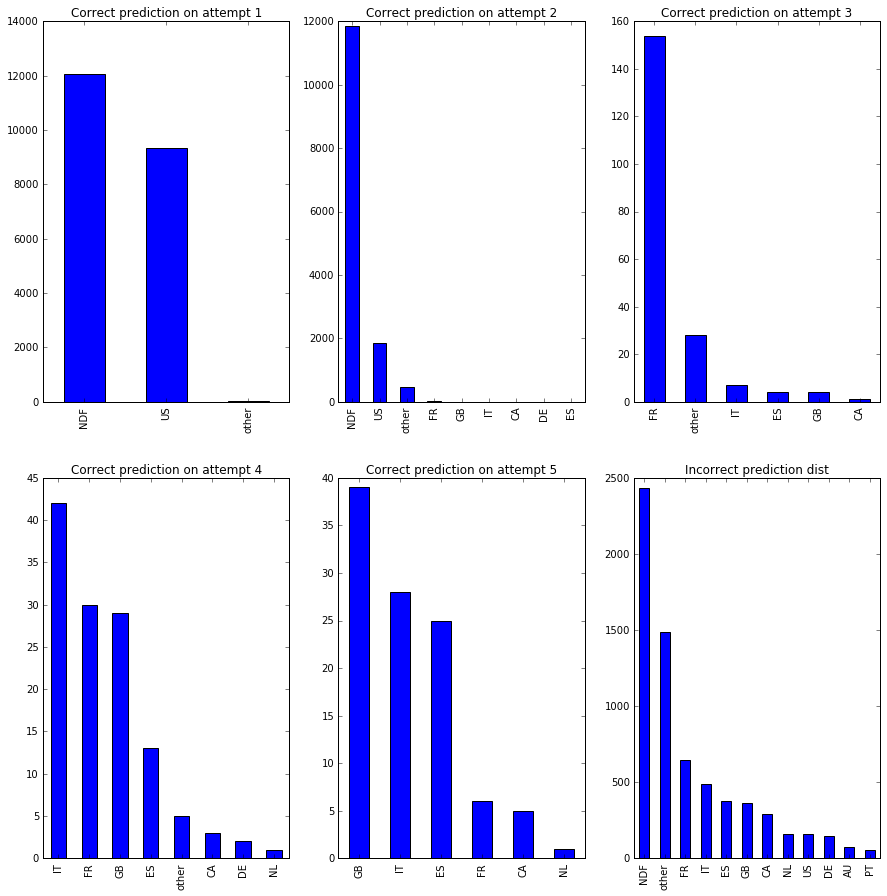

In [427]:
# Create a 3-level model using NDF, US, and other models.
# Compute accuracy on dev set.
lr_ndf_dev_prob = lr_ndf.predict_proba(dev_x)
lr_us_dev_prob = rf_us.predict_proba(dev_x)
vc_other_dev_prob = vc_other.predict_proba(dev_x)
predictions = []
case1, case2, case3 = 0, 0, 0
for i in range(dev_x.shape[0]):
    ndf_prob = lr_ndf_dev_prob[i][1]
    us_prob = lr_us_dev_prob[i][1]
    max_other_prob = np.max(vc_other_dev_prob[i])
    if (ndf_prob > us_prob and ndf_prob > max_other_prob):
        case1+=1
        predictions.append((dev_id[i], 'NDF'))
        if (us_prob > max_other_prob):
            predictions.append((dev_id[i], 'US'))
        else:
            sorted_scores = np.sort(vc_other_dev_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_dev_prob[i].tolist().index(score)
                predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
    elif (us_prob > ndf_prob and us_prob > max_other_prob):
        case2+=1
        predictions.append((dev_id[i], 'US'))
        if (ndf_prob > max_other_prob):
            predictions.append((dev_id[i], 'NDF'))
        else:
            sorted_scores = np.sort(vc_other_dev_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_dev_prob[i].tolist().index(score)
                predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
    else:
        case3+=1
        sorted_scores = np.sort(vc_other_dev_prob[i])
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = vc_other_dev_prob[i].tolist().index(score)
            predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
print "Case 1 count: {0}".format(case1)
print "Case 2 count: {0}".format(case2)
print "Case 3 count: {0}".format(case3)
print "Final Score: {0}".format(FinalScore(predictions))
Dump(predictions)

In [429]:
# Run 3-level model on test data.
lr_ndf_predictions_test = lr_ndf.predict(test_data_x)
lr_us_predictions_test = lr_us.predict(test_data_x)
vc_other_test_prob = vc_other.predict_proba(test_data_x)
predictions = []
for i in range(test_data_x.shape[0]):
    if (lr_ndf_predictions_test[i] == 1):
        predictions.append((test_data["id"][i], 'NDF'))
        if (lr_us_predictions_test[i] == 1):
            predictions.append((test_data["id"][i], 'US'))
        else:
            sorted_scores = np.sort(vc_other_test_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_test_prob[i].tolist().index(score)
                predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
    elif (lr_us_predictions_test[i] == 1):
        predictions.append((test_data["id"][i], 'US'))
        if (lr_ndf_predictions_test[i] == 1):
            predictions.append((test_data["id"][i], 'NDF'))
        else:
            sorted_scores = np.sort(vc_other_test_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_test_prob[i].tolist().index(score)
                predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
    else:
        sorted_scores = np.sort(vc_other_test_prob[i])
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = vc_other_test_prob[i].tolist().index(score)
            predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
# output8 = pd.DataFrame(predictions, columns=["id", "country"])
# version = 8
# output8.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)

### Log of Improvements
1. Multinomial NB  
Baseline score: 0.63168  
Baseline rank: 1304  
2. Multinomial NB with Top 5 predictions  
Score: 0.79584  
Rank: 1142
3. Logistic Regression with Top 5 predictions  
Score: 0.85894  
Rank: 1049
4. Random Forest with Top 5 predictions  
Score: 0.81781  
Rank: 1138  
5. Logistic Regression with Age data clean-up  
Score improvement: 0.85970  
Rank improvement: 1044  
6. Soft voting with Logistic Regression and Random Forest   
Score improvement: 0.86252  
Rank improvement: 1032  
7. 3-Level Model with NDF specific model, US specific model, and all other countries model  
Sore: 0.78481  
Rank: 1142

# Error Analysis

In [182]:
import operator
def error_analysis(model, dev_x, dev_y):
    """
    Due to the large frequence of NDFs, the matrix needs to be normalized if we're to see anything helpful in this viz.
    """
    preds = model.predict(dev_x) ##Compute predictions given model
    labels = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']    
    ###Accuracy Statistics###
    print 'FinalScore metric value: ', FinalScore(Predict_Top5(model))
    print "precision answers: where we measure 'country', what fraction actually was 'country'?"
    print "recall answers: of all that were 'country', what fraction did we correctly predict 'country'?"
    print "goal is to have both high precision and recall scores"
    print 'Precision and Recall scores: \n'
    precision = []
    recall = []
    for country in labels:
        binarized_devy = dev_y == country
        binarized_preds = preds == country
        precision.append(metrics.precision_score(binarized_devy, binarized_preds))
        recall.append(metrics.recall_score(binarized_devy, binarized_preds))
    p_r_dict = {'precision':precision, 'recall':recall}
    p_r_df = pd.DataFrame(p_r_dict, index=labels)
    print p_r_df
    ###Confusion Matrix###
    c_matx = metrics.confusion_matrix(dev_y, preds)
    c_matx_n = c_matx.astype('float') / c_matx.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(c_matx_n, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ###Error count###
    sums = {}
    series = {}
    for i in range(len(c_matx)):
        sums[labels[i]] = 0
        labs = []
        data = []
        for j in range(len(c_matx[i])):
            if i != j:
                sums[labels[i]] += c_matx[i][j]
                labs.append(labels[j])
                data.append(c_matx[i][j])
        series[labels[i]] = pd.Series(data, index=labs)
        series[labels[i]].sort_values(inplace=True, ascending=False)
    sorted_sums = sorted(sums.items(), key=operator.itemgetter(1), reverse=True)
    error_counts = pd.Series([x[1] for x in sorted_sums], [x[0] for x in sorted_sums])
    print 'Error Counts: \n\n', error_counts
    ###Top 5 Error Histograms###
    plt.figure(figsize=(15, 30))
    plt_indx = 1
    for country in [x[0] for x in sorted_sums[0:5]]:
        plt.subplot(5,1,plt_indx)
        series[country].plot.bar()
        plt.title("For '" + country + "' the model incorrectly guessed...")
        plt_indx += 1

FinalScore metric value:  0.83039644862
precision answers: where we measure 'country', what fraction actually was 'country'?
recall answers: of all that were 'country', what fraction did we correctly predict 'country'?
goal is to have both high precision and recall scores
Precision and Recall scores: 

       precision    recall
AU      0.000000  0.000000
CA      0.000000  0.000000
DE      0.000000  0.000000
ES      0.000000  0.000000
FR      0.029851  0.002358
GB      0.000000  0.000000
IT      0.000000  0.000000
NDF     0.712951  0.857349
NL      0.000000  0.000000
PT      0.000000  0.000000
US      0.470296  0.450851
other   0.081081  0.001507
Error Counts: 

US       6229
NDF      3759
other    1988
FR        846
IT        564
GB        435
ES        418
CA        300
NL        160
DE        150
AU         77
PT         54
dtype: int64


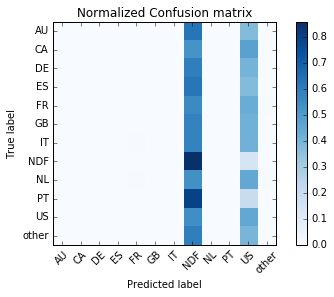

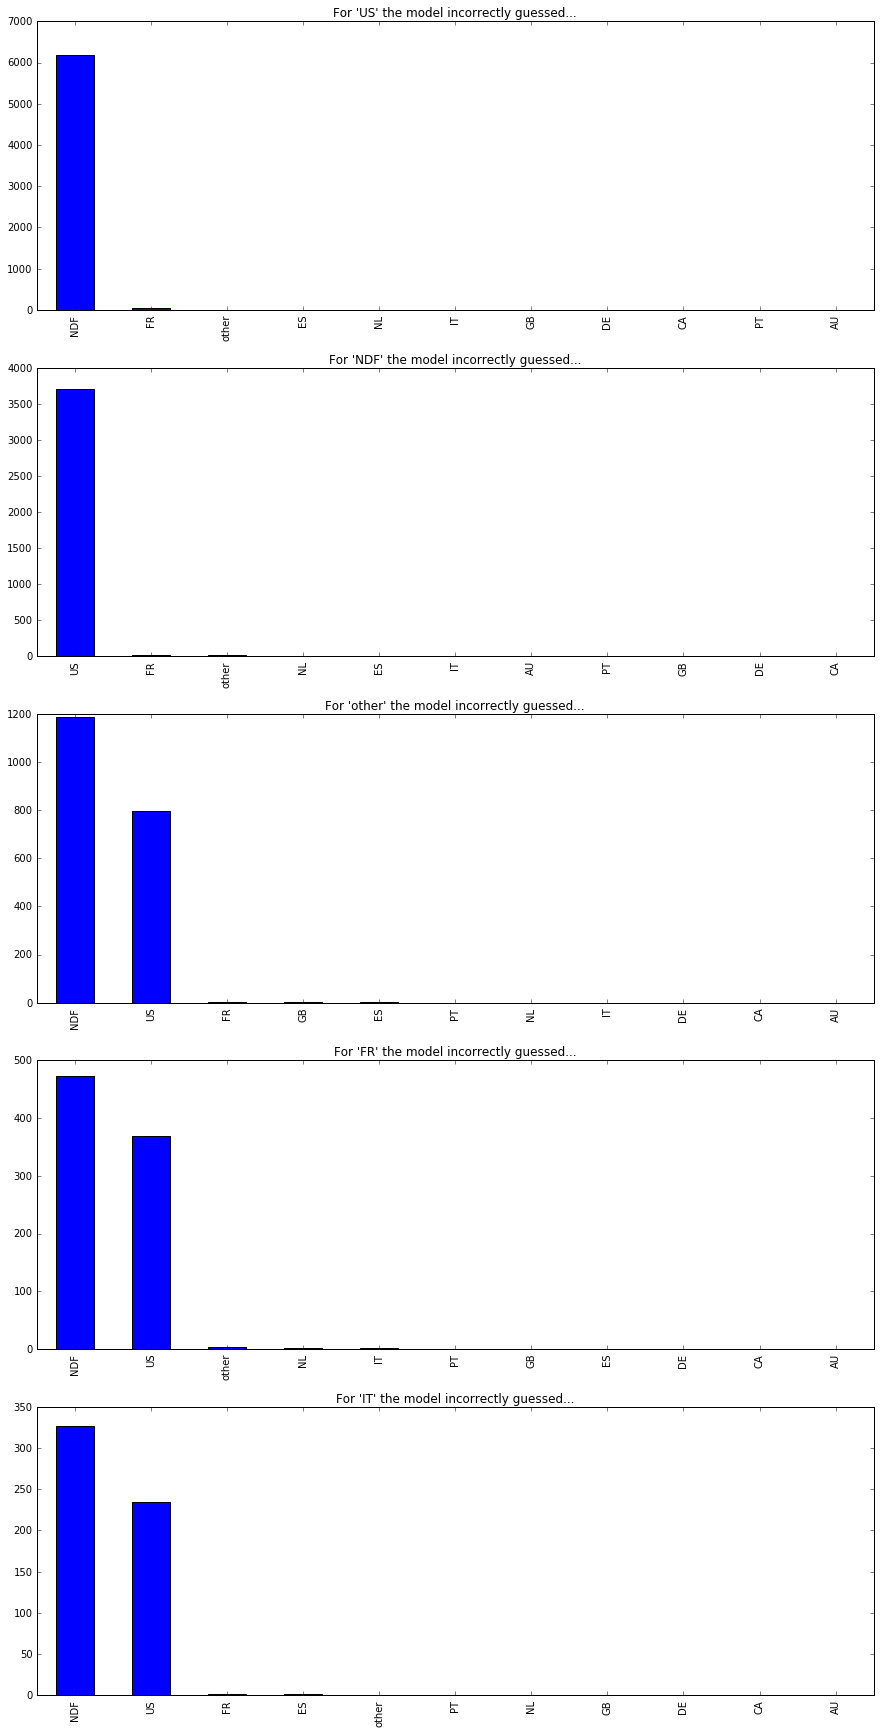

In [183]:
error_analysis(vc, dev_x, dev_y)